## **Classifier of lightnings with Multilayer Perceptron (MLP)**

In the field of Electrical Engineering more specifically on 
atmosferic discharges some laboratories/observatories of lightning deal daily with a huge amount of data generated from sensors that are continuously monitoring the weather in search of lightnings, the way to track this 
phenomenon is by measuring the changes in electromanetic fields. Thus a waveform of the lightning is defined for 'x' distance. In other words a waveform for a lightning that happend at 10 km is different of one that occurred at 60 km or 100 km. So the distance matter. The actual procedure extract some data is manual and save mode is kind of 'whatever', all the data is placed together. To overcome this is proposed the use of Artificial Neural Network (ANN) of the type Multilayer Perceptron (MLP) that could classify a set of data colected by Lightning Observatory in Gainesville (LOG), Florida, on the Lightning
Detection and Waveform Storage System (LDWSS). The data is initially divided according to the time it was recorded:

*   Day
*   Night

It is due to the effects that the Sun has on Ionosphere and consequently on signal that comes from a lightning - less noisy at night. After dividing between night and day, it's time to label the data according the distance, for this the waveform is the resposible for defining each class, in this case the first label will be all the events that happend at a distance of 20 km - label 0, the next will be the same but a different distance, here is 50 km - label 1, this will continue till reach the last that is 490 km - label 11. In this case I'm dealing with a multiclass classification.
This is the normalized waveform of a lightning within 20 km during the day, the digitalization here corresponds to 1100 samples, in time 1.1 millisecond: 

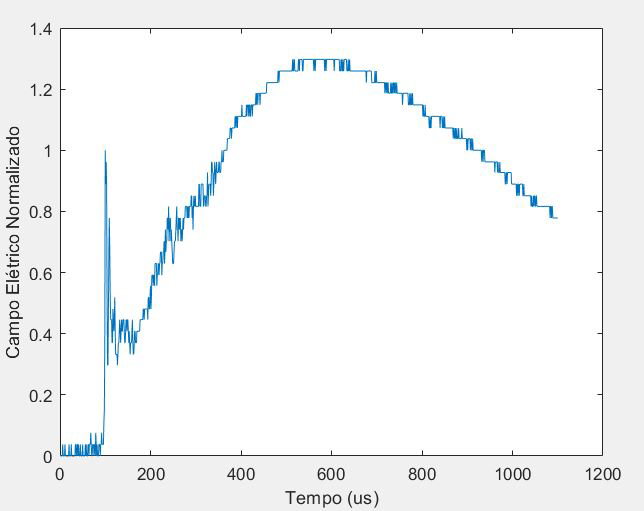


Note the long ramp after the abrupt increase on electromagnetic field. This will not appear on night waveform. 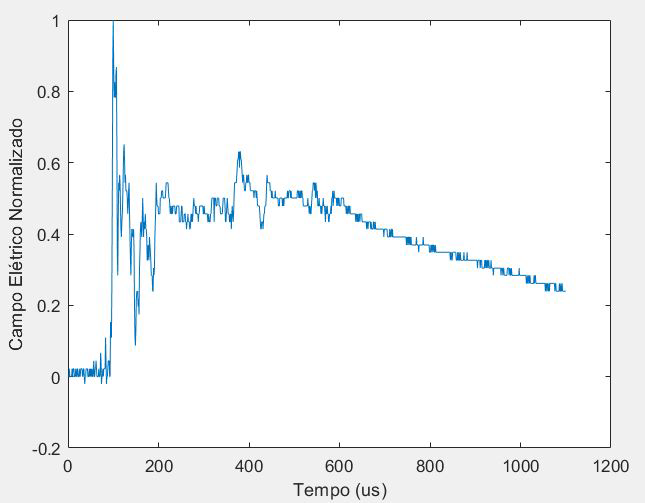

Now let's take a look at how is the format of a wave localizated at 200 km during the day and night, respectively: 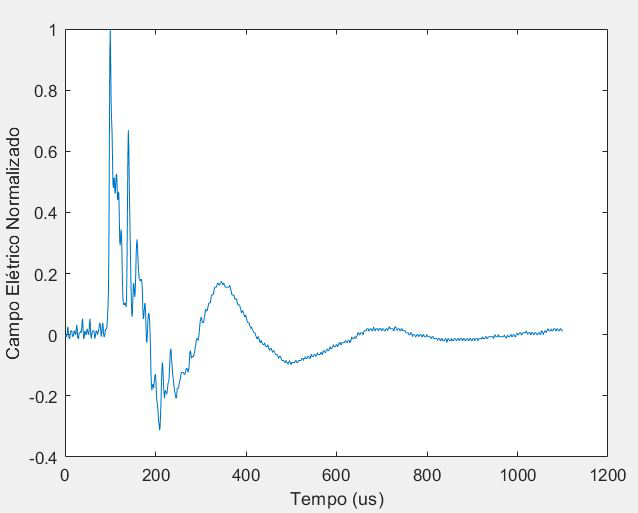

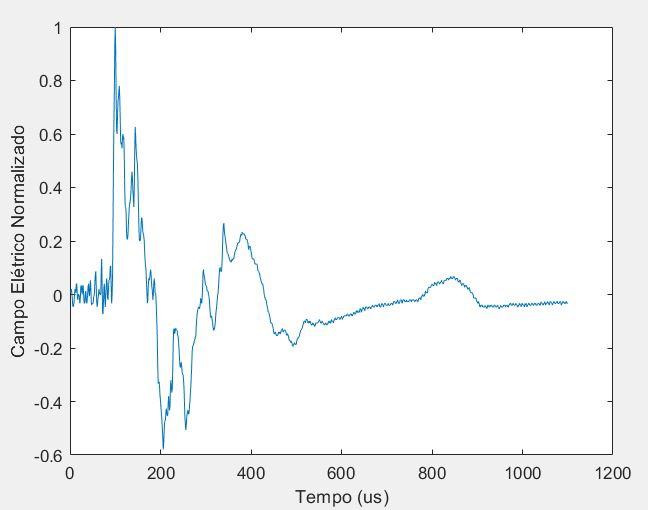

As seen the line for night seems to be more noisy at night for long distances, contraty to what happens in the morning.

Taking this into consideration, let's start the build of a model to classify this data. The set of data is of 1255 flashes for day, each one having 1100 
attributes, containing 11 classes and for night a set of 270 flashes, each one having 1100 attributes with 6 classes. The following packets are the ones that will be used.

In [3]:
import tensorflow as tf
import pandas as pd
from keras.layers import Dense
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


On the next lines I'll get the data that are stored on a '.csv' and start to manipulate it.

In [4]:
# classification dataset
raw_data = open('night.csv', 'rt')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader) # cast to list
data = np.array(x) # convert to an array

Getting the shape and size of the data. For night the 6 classes are with imbalanced quantity of flashes this can affect the performance of the model, an unbalanced dataset will bias the prediction model towards the more common class!

In [5]:
# one hot encode output variable
X, Y = data[:, :-1].astype(float), data[:, -1]
print(X.shape, Y.shape)
da = Y
counter = Counter(Y)
print(counter)

(270, 1100) (270,)
Counter({'2': 81, '3': 67, '1': 54, '4': 30, '0': 25, '5': 13})


Here just to plot the quantities of cases for each class before the balancement

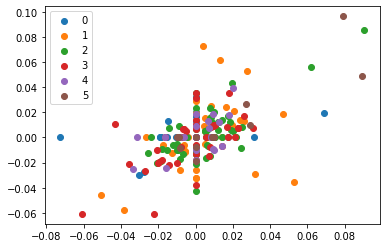

In [6]:
for label, _ in counter.items():
	warnings.simplefilter(action='ignore', category=FutureWarning)
	row_ix = np.where(Y == label)[0]
	plt.figure(3)
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Now to equalize the quantities of cases and lead to a better performance in the minority class, the approach used here is oversample the minority class, synthesizing new examples from the existing examples, this is a kind of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique - 
*acronym* SMOTE. Some examples could be seen at [Machine Learning Mastery.](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [7]:
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)
print(X.shape, Y.shape)
counter = Counter(Y)
print(counter)

(486, 1100) (486,)
Counter({'0': 81, '1': 81, '2': 81, '3': 81, '4': 81, '5': 81})


So now the entire data set has 486 flashes, 216 more, almost the doble of previous all classes are with the same quantity of flashes '81'.

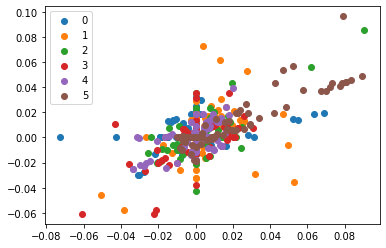

In [8]:
for label, _ in counter.items():
	warnings.simplefilter(action='ignore', category=FutureWarning)
	row_ix = np.where(Y == label)[0]
	plt.figure(4)
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

The increase of flashes is visible for each class. After this is time to split the quantity of data for training and test, train_test_split do it easily, it's a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data. By default, Sklearn train_test_split will make random partitions for the two subsets. X and y parameters means which dataset you're selecting to use. The test_size is defined is 0.3 and consequently train_size is 0.7

In [9]:
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
Y = to_categorical(Y, num_classes=6)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                                        random_state=1)

In [11]:
print(X_train.shape, X_test.shape, y_test.shape, y_train.shape)
y_verdade = y_test[:, :len(y_test)]
a = [np.where(r == 1)[0][0] for r in y_verdade]

(340, 1100) (146, 1100) (146, 6) (340, 6)


The following image is the model that will be implemented using keras.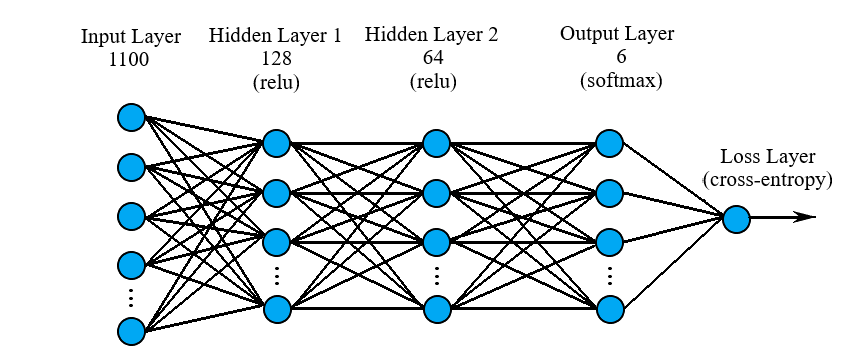

Relu in this case performed better than sigmoid. There's a good explanation at [Stack Exchange.](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks)

In [12]:
# define model
model = Sequential()
# Dense(128) is a fully-connected layer with 128 hidden units
# in the first layer, you must specify the expected input data shape:
# in this case, 1100-dimensional vectors.
model.add(Dense(128, input_dim=1100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
# compile model
opt = SGD(lr=0.01, decay=1e-6,  momentum=0.9, nesterov=True)
#opt = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
esCallback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=150, verbose=0, callbacks=[esCallback])

SGD is prefered because it seems to have a smoother convergence instead Adam.

In [13]:
# evaluate the model
y_pred = model.predict_classes(X_test)
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
classes=[0, 1, 2, 3, 4, 5]

np.seterr(divide='ignore', invalid='ignore')
con_mat = tf.math.confusion_matrix(labels=a, predictions=y_pred).numpy()
print(a, y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[2, 2, 3, 4, 3, 4, 3, 3, 1, 0, 1, 1, 4, 3, 1, 4, 0, 0, 5, 5, 4, 1, 3, 2, 3, 3, 2, 5, 0, 4, 0, 3, 0, 0, 5, 4, 5, 0, 3, 5, 4, 1, 1, 1, 1, 4, 1, 4, 0, 3, 2, 4, 0, 0, 0, 0, 1, 5, 5, 2, 0, 1, 3, 5, 1, 5, 0, 2, 2, 1, 2, 5, 2, 5, 1, 4, 5, 0, 5, 2, 2, 5, 5, 3, 0, 0, 4, 4, 0, 4, 0, 3, 5, 2, 4, 5, 4, 1, 4, 1, 2, 3, 1, 2, 0, 5, 4, 3, 4, 3, 1, 0, 1, 5, 0, 1, 4, 5, 2, 0, 5, 3, 2, 1, 4, 0, 2, 2, 4, 2, 0, 4, 5, 3, 3, 3, 2, 3, 5, 5, 0, 3, 2, 2, 0, 0] [2 2 3 4 3 4 3 3 1 0 1 1 4 3 1 4 0 0 5 5 4 1 3 2 3 3 2 5 0 4 0 3 0 0 5 4 5
 0 3 5 4 2 1 1 1 4 1 4 0 3 2 4 0 0 0 0 1 5 1 2 0 1 3 5 1 5 0 2 2 1 2 5 2 5
 1 4 5 0 5 2 2 5 5 3 0 0 4 4 0 4 0 3 5 2 4 5 4 1 4 1 2 3 1 2 0 5 4 3 4 3 1
 0

After train the model we can match what was predicted and what is the real class number and check the average errors.

In [16]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

A simple way to save the trained model

In [17]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.991, Test: 0.979


Now we could plot the results. The confusion matrix indicates the percentage for each one of the classes in question, the columns means the real classes and the rows are the predictions made by the model, all correct predictions are located in the diagonal of the table (highlighted in dark blue). For last a representation of a part of lightnings of class six.

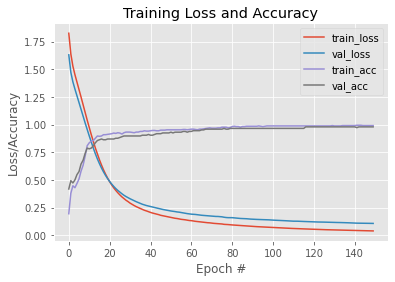

No handles with labels found to put in legend.


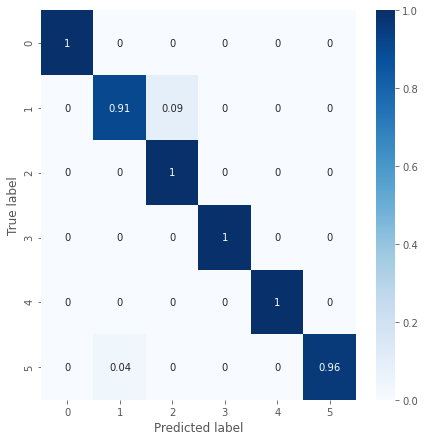

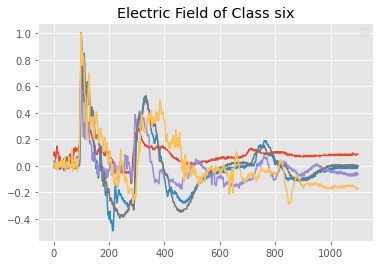

In [21]:
# plot loss during training
plt.style.use("ggplot")
plt.figure(1)
plt.title("Training Loss and Accuracy")
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plot accuracy during training
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

plt.figure(2, figsize=(6, 6))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

#pd.read_csv('noite - noite.csv', header=None).T.to_csv('output.csv', header=False, index=False)
r_data = open('output.csv', 'rt')
Xzip = csv.reader(r_data, delimiter=',', quoting=csv.QUOTE_NONE)
xz = list(Xzip)
datra = np.array(xz)
# XT = datra[:-1, :].astype(float)

df = pd.read_csv(('output.csv'))
ax = plt.gca()
data_frame = df.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]

for i in range(5, 10):
	plt.figure(5)
	plt.title("Electric Field of Class six")
	ax = plt.gca()
	df.plot(label='_Hidden label', kind='line',y=f'six{i}', legend=False, ax=ax)

plt.legend()
plt.show()
